# Working with Raster Data in Python

Python has an ecosystem of packages to work with Geospatial data. The most important packages to work with Raster data are:

- [Rasterio](https://rasterio.readthedocs.io/en/latest/index.html) is a highly useful module for raster processing which you can use for reading and writing [several different raster formats](https://gdal.org/drivers/raster/index.html) in Python. Rasterio is based on [GDAL](http://www.gdal.org/). Most common file formats that can be read with `Rasterio` include for example TIFF, GeoTIFF, ASCII Grid and Erdas Imagine (.img) files.
- [xarray](https://docs.xarray.dev/en/stable/getting-started-guide/index.html) is a package to create array objects similar to numpy arrays, but store extra information (dimensions, coordinates, coordinate reference system, time). Data model based on NetCDF. Xarray has built in functionality for parallel computing. 
- [rioxarray](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) is basically an extension for `xarray` based on `rasterio`. With rioxarray you can read geospatial data files directly into `xarray` objects.
- [matplotlib](https://matplotlib.org/) is the most common plotting library in Python, inspired by the plotting functionalities of MATLAB
- [earthpy](https://pypi.org/project/earthpy/) provides some extra plotting functionalities specifically for geospatial datasets.


## Reading raster file (rioxarray/rasterio)

For reading data we use the `rioxarray` package. `rasterio` also has functions to read data, with this package you will get a slightly different data type that has slightly different functionalities. Basically you could do most of the steps below by using `rasterio`, but the commands will look slightly different.

In [3]:
import rioxarray
import os
%matplotlib inline

# Data dir
data_dir = "../data/Beeldmateriaal/"
fp = os.path.join(data_dir, "USP_4Band_RGBN.tif")

# Open the file:
raster = rioxarray.open_rasterio(fp, band_as_variable = True)

# Check type of the variable 'raster'
type(raster)

xarray.core.dataset.Dataset

## Exploring file structure (Dataset class)

It is always good to explore a bit the structure and content of data objects before working with it. Especially with geospatial data you want to know the dimensions, the coordinate reference system and the number of layers or bands.

In [4]:
raster

<xarray.Dataset>
Dimensions:      (x: 8204, y: 5956)
Coordinates:
  * x            (x) float64 1.395e+05 1.395e+05 ... 1.416e+05 1.416e+05
  * y            (y) float64 4.561e+05 4.561e+05 ... 4.546e+05 4.546e+05
    spatial_ref  int64 0
Data variables:
    band_1       (y, x) uint8 ...
    band_2       (y, x) uint8 ...
    band_3       (y, x) uint8 ...
    band_4       (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:  Area

### Extracting bands into separate objects

We will now create objects of each of the spectral bands of the image. It is not strictly necessary to do this (it is a bit inefficient to make copies of the data), but it makes the python code below better readable and intuitive.

In [5]:
blue = raster["band_3"]
green = raster["band_2"]
red = raster["band_1"]
nir = raster["band_4"]
blue

<xarray.DataArray 'band_3' (y: 5956, x: 8204)>
[48863024 values with dtype=uint8]
Coordinates:
  * x            (x) float64 1.395e+05 1.395e+05 ... 1.416e+05 1.416e+05
  * y            (y) float64 4.561e+05 4.561e+05 ... 4.546e+05 4.546e+05
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  2893.64616988154,2647.237559987611,2703.46801314...
    STATISTICS_MAXIMUM:      255
    STATISTICS_MEAN:         88.773649907529
    STATISTICS_MEDIAN:       75,000000
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       51.994884490148
    scale_factor:            1.0
    add_offset:              0.0

In [6]:
print(red.rio.crs)
print(red.rio.nodata)
print(red.rio.bounds())
print(red.rio.width)
print(red.rio.height)

EPSG:28992
None
(139504.5, 454623.25, 141555.5, 456112.25)
8204
5956


You can see that the individual bands are a different data type (`xarray.DataArray` instead of `xarray.Dataset`). The `DataArray` is slightly simpler, but still contains the dimensions and coordinates of the image.

### Visualizing bands

`xarray.DataArray` s have a built-in plot method (this is based on the plotting functions from the `matplotlib` package). We can create plots for the red band by running this command:

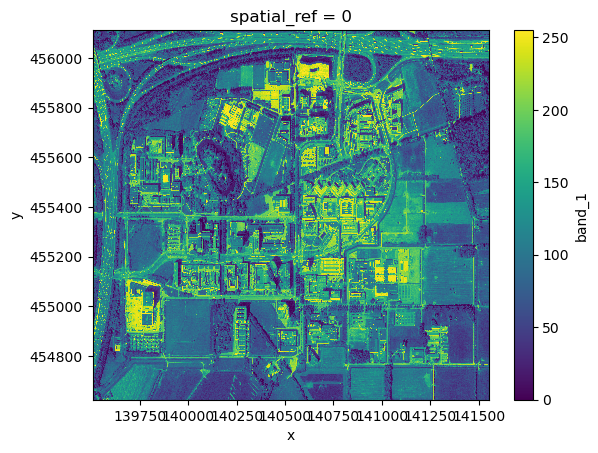

In [7]:
red.plot()

## Coordinate Reference Systems

To define the location of something you often use a coordinate reference system (CRS). This system consists of an X and a Y value located within a 2 (or more) -dimensional space. Because we typically make rectangular maps from an area on a (not perfectly shaped) sphere, 'we' invented an big number of CRSs to make this maps look pretty. The downside of this is that you can collect different datasets in different CRSs which can be a pain to work with. Luckily there are tools to convert a CRS to a different CRS.

A coordinate reference system is made up of several key components:

- Coordinate system: The X, Y grid upon which your data is overlayed and how you define where a point is located in space.
- Horizontal and vertical units: The units used to define the grid along the x, y (and z) axis.
- Datum: A modeled version of the shape of the Earth which defines the origin used to place the coordinate system in space. You will learn this further below.
- Projection Information: The mathematical equation used to flatten objects that are on a round surface (e.g. the Earth) so you can view them on a flat surface (e.g. your computer screens or a paper map).

Commonly used CRSs include: 

WGS 84: https://epsg.io/4326  
UTM31N: https://epsg.io/32631

## CRS conversion

Actually I find the coordinates in the plot above not really intuitive. I prefer "lat, long", so degrees latitude and longitude. Let's change the CRS using the `crs` module from the `rasterio` package.

In [15]:
from rasterio.crs import CRS

crs_wgs84 = CRS.from_string('EPSG:4326')

In [9]:
red_wgs84 = red.rio.reproject(crs_wgs84)

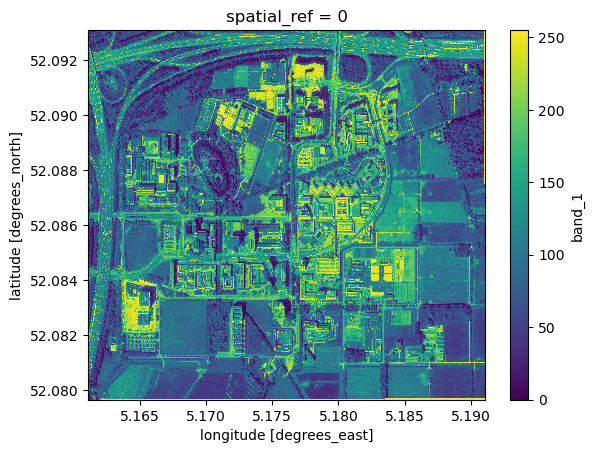

In [16]:
red_wgs84.plot()

As you can see, the coordinates and labels have changed. We can also inspect the `DataArray` to see what changed:

In [11]:
red_wgs84

<xarray.DataArray 'band_1' (y: 4151, x: 9264)>
array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
Coordinates:
  * x            (x) float64 5.161 5.161 5.161 5.161 ... 5.191 5.191 5.191 5.191
  * y            (y) float64 52.09 52.09 52.09 52.09 ... 52.08 52.08 52.08 52.08
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  3330.019638876049,2964.962276019155,2893.6461698...
    STATISTICS_MAXIMUM:      255
    STATISTICS_MEAN:         106.19299853403
    STATISTICS_MEDIAN:       97,000000
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       57.706322347521
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              255

## Cropping

Now, let's say we want to zoom in to the area where we are currently are and do some analysis on the vegetation in this area. We will first need to crop the image. It is best to do this first, it will result in a smaller image that is easier to work with. We can use the `clip_box` method to do this. We will do this for the reprojected red spectral band image first:

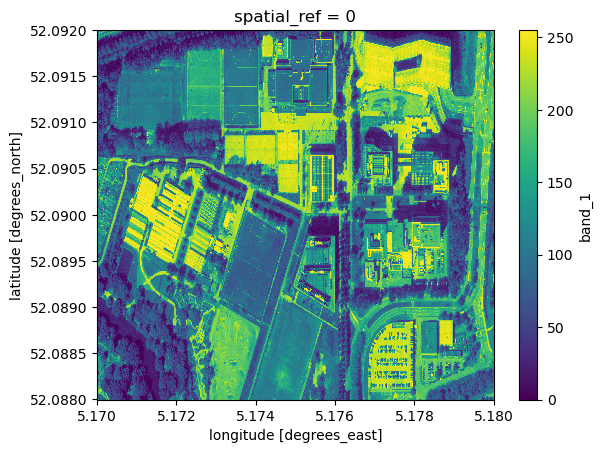

In [12]:
red_clipped = red_wgs84.rio.clip_box(
    minx=5.170,
    miny=52.088,
    maxx=5.180,
    maxy=52.092,
)
red_clipped.plot()

And now there is the very convenient function `reproject_match` that will -in one go- perform the reprojection and cropping step that we now only applied to the red spectral band. Basically it will make sure the `xarray.DataArray` object it will be applied on has the same dimensions and coordinates as another object that we specify:

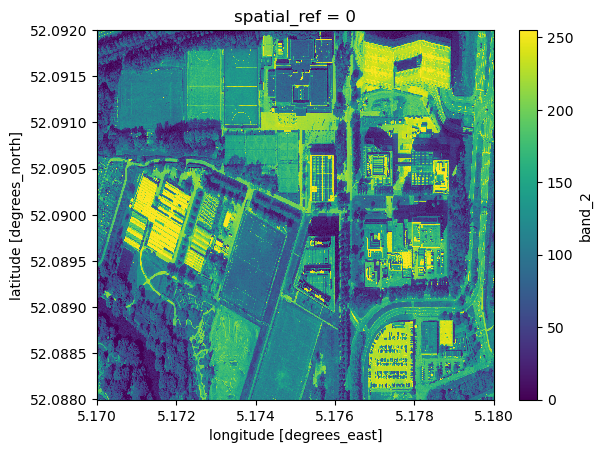

In [17]:
green_clipped = green.rio.reproject_match(red_clipped)
green_clipped.plot()

Similarly we will apply this method on the blue and near infrared spectral bands:

In [18]:
blue_clipped = blue.rio.reproject_match(red_clipped)
nir_clipped = nir.rio.reproject_match(red_clipped)

## Composing a True color (or RGB) image

We can use the red, green and blue spectral bands to create a true color image. As you can see in the legends above the values are scaled between 0 and 255. For composing the image we need to normalize the values first:

In [30]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red_clipped)
greenn = normalize(green_clipped)
bluen = normalize(blue_clipped)
nirn = normalize(nir_clipped)

print("Normalized bands")
print(redn.values.min(), '-', redn.values.max(), 'mean:', redn.values.mean())
print(greenn.values.min(), '-', greenn.values.max(), 'mean:', greenn.values.mean())
print(bluen.values.min(), '-', bluen.values.max(), 'mean:', bluen.values.mean())

Normalized bands
0.0 - 1.0 mean: 0.47605566423067236
0.0 - 1.0 mean: 0.4599640338458991
0.0 - 1.0 mean: 0.4039841718553451


Now let's merge the three bands into one (`DataArray`) object. For this we can use the `merge` function from the `xarray` package:

In [20]:
import xarray as xr

# Create RGB natural color composite
#rgb = xr.merge([red_clipped, green_clipped, blue_clipped]).to_array()
rgb = xr.merge([redn, greenn, bluen]).to_array()

rgb

<xarray.DataArray (variable: 3, y: 1237, x: 3090)>
array([[[0.31372549, 0.32941176, 0.32156863, ..., 0.70196078,
         0.71764706, 0.74117647],
        [0.3254902 , 0.32941176, 0.38039216, ..., 0.69019608,
         0.70980392, 0.70196078],
        [0.2745098 , 0.25882353, 0.3254902 , ..., 0.68627451,
         0.71372549, 0.72941176],
        ...,
        [0.38039216, 0.41568627, 0.38039216, ..., 0.43137255,
         0.4       , 0.43137255],
        [0.34901961, 0.39607843, 0.39215686, ..., 0.38039216,
         0.36470588, 0.41176471],
        [0.37254902, 0.36470588, 0.39215686, ..., 0.43137255,
         0.3372549 , 0.41176471]],

       [[0.3372549 , 0.35294118, 0.34509804, ..., 0.62745098,
         0.65098039, 0.67843137],
        [0.34901961, 0.35294118, 0.41176471, ..., 0.61960784,
         0.63921569, 0.62745098],
        [0.27843137, 0.34901961, 0.3372549 , ..., 0.65098039,
         0.59607843, 0.78823529],
...
        [0.35294118, 0.39607843, 0.35294118, ..., 0.4       ,
         0.36470588, 0.4       ],
        [0.32156863, 0.37254902, 0.36470588, ..., 0.33333333,
         0.31372549, 0.36078431],
        [0.34509804, 0.3372549 , 0.36470588, ..., 0.38823529,
         0.26666667, 0.36470588]],

       [[0.21960784, 0.23921569, 0.22745098, ..., 0.59215686,
         0.61176471, 0.64313725],
        [0.23137255, 0.23921569, 0.30196078, ..., 0.58039216,
         0.6       , 0.59215686],
        [0.16078431, 0.23921569, 0.20784314, ..., 0.61176471,
         0.55686275, 0.75686275],
        ...,
        [0.2627451 , 0.30588235, 0.2627451 , ..., 0.31372549,
         0.2745098 , 0.31372549],
        [0.22745098, 0.28235294, 0.2745098 , ..., 0.22745098,
         0.20784314, 0.2745098 ],
        [0.25098039, 0.24313725, 0.2745098 , ..., 0.29019608,
         0.16078431, 0.2627451 ]]])
Coordinates:
  * x            (x) float64 5.17 5.17 5.17 5.17 5.17 ... 5.18 5.18 5.18 5.18
  * y            (y) float64 52.09 52.09 52.09 52.09 ... 52.09 52.09 52.09 52.09
    spatial_ref  int64 0
  * variable     (variable) object 'band_1' 'band_2' 'band_3'

Now we can plot the true color image:

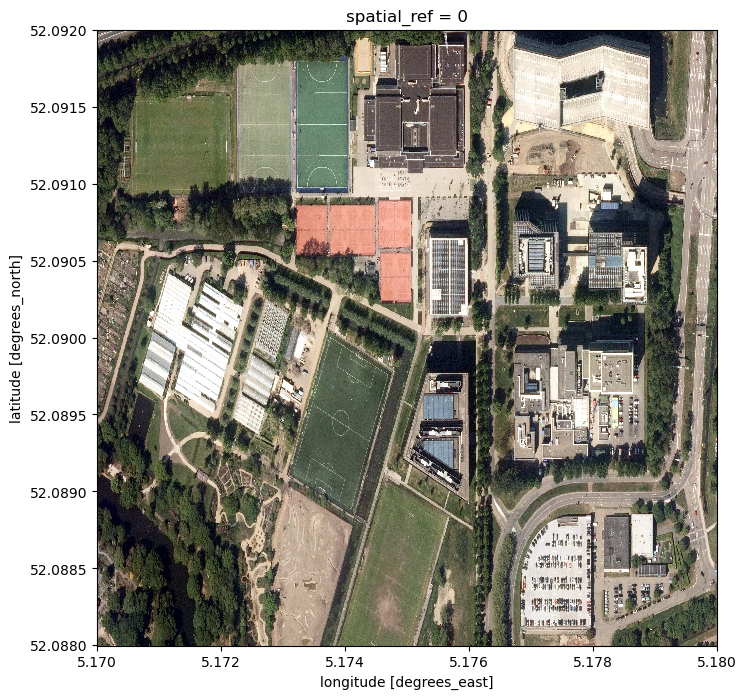

In [21]:
rgb.plot.imshow(figsize=(8,8))

## NDVI and raster maths

It is possible to do all kinds of mathematical operations using 1 or more raster layers. We have already seen how to normalize a raster layer above. Now we will combine the red and infrared spectral bands to calculate the Normalized Difference Vegetation Index (NDVI):

$$ NDVI = \frac{NIR - red}{NIR + red} $$

This index is commonly used to quantify the amount of green leaf.

First, let's check if the shape of the rasters is the same:

In [32]:
print(redn.shape)
print(nirn.shape)

(1237, 3090)
(1237, 3090)


Now we simply use the formula above where we use the bands.

In [23]:
ndvi = (nirn - redn)/ (nirn + redn)

In [24]:
ndvi

<xarray.DataArray (y: 1237, x: 3090)>
array([[ 0.44636678,  0.43434343,  0.4440678 , ..., -0.12578616,
        -0.11926606, -0.11176471],
       [ 0.43537415,  0.43434343,  0.40123457, ..., -0.12820513,
        -0.1242236 , -0.12225705],
       [ 0.46969697,  0.52173913,  0.42758621, ..., -0.10759494,
        -0.16666667, -0.00540541],
       ...,
       [ 0.34459459,  0.32698413,  0.33788396, ...,  0.30599369,
         0.32      ,  0.29487179],
       [ 0.36654804,  0.33770492,  0.33774834, ...,  0.31690141,
         0.32608696,  0.28813559],
       [ 0.34482759,  0.35416667,  0.33774834, ...,  0.28571429,
         0.328125  ,  0.2733564 ]])
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 5.17 5.17 5.17 5.17 5.17 ... 5.18 5.18 5.18 5.18
  * y            (y) float64 52.09 52.09 52.09 52.09 ... 52.09 52.09 52.09 52.09

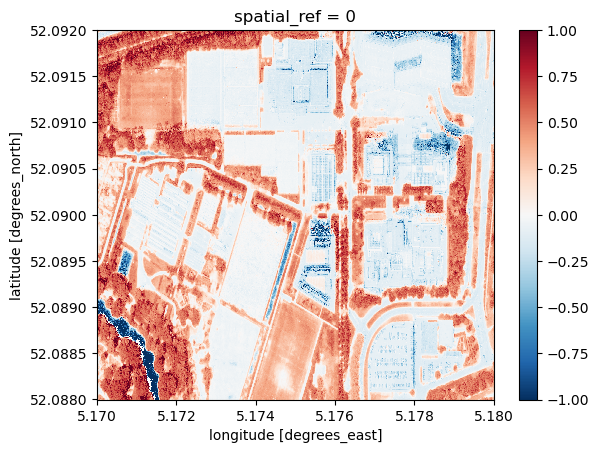

In [25]:
ndvi.plot()

## plot statistics (histogram)

(array([  30388.,   15582.,   40447.,  138340., 1601334.,  431641.,
         627964.,  653108.,  224044.,   55245.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

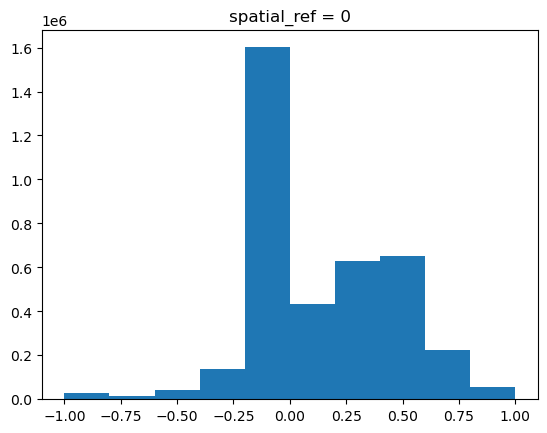

In [26]:
ndvi.plot.hist()

In [27]:
ndvi_nonan = ndvi.interpolate_na(dim="x")
ndvi_nonan.rio.to_raster("NDVI.tif")

## Image classification

In [28]:
import numpy as np
import xarray

# Defines the bins for pixel values
class_bins = (-1, -0.35, 0.2, 0.5, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

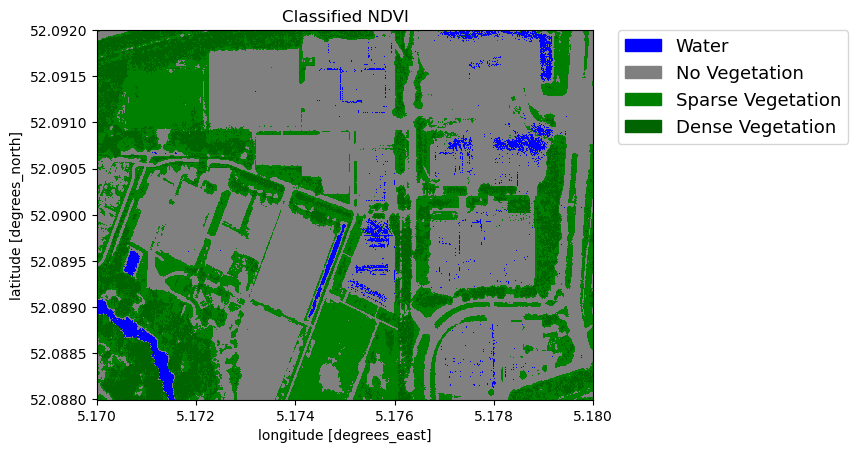

In [29]:
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save the figure
plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

## Main concluding messages
Advantages (repeatable, exact, scalable, publishable)